## Recursive Bayesian Estimation

- https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation
- https://en.wikipedia.org/wiki/Particle_filter

1. Simple Gaussian observations. Grid-based.
2. Particle Filter.

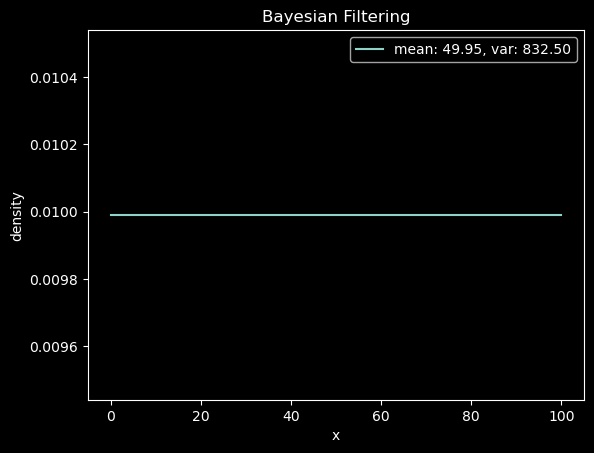

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from IPython.display import clear_output

# grid
x = np.linspace(0, 100, 1000)
dx = x[1] - x[0]

# (initial) prior: uniform on [0, 100]
prior = uniform.pdf(x, loc=0, scale=100)
prior /= prior.sum() * dx  # normalize
mean = np.trapezoid(prior * x, x)
var = np.trapezoid((x - mean)**2 * prior, x)


plt.plot(x, prior, label=f'mean: {mean:.2f}, var: {var:.2f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.title('Bayesian Filtering')
plt.show()


while True: 
    try: 
        observation, obs_sigma = input("observation obs_sigma: ").split()
    except ValueError:
        break
    
    observation = float(observation)
    obs_sigma = float(obs_sigma)
    
    likelihood = norm.pdf(x, loc=observation, scale=obs_sigma)

    # Bayesian update: elementwise multiple, then normalize
    posterior = prior * likelihood
    posterior /= posterior.sum() * dx
    mean = np.trapezoid(prior * x, x)
    var = np.trapezoid((x - mean)**2 * prior, x)

    # plot
    clear_output(wait=True)
    plt.plot(x, posterior, label=f'mean: {mean:.2f}, var: {var:.2f}')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('density')
    plt.title('Bayesian Filtering')
    plt.show()

    prior = posterior


The variance of the posterior distribution decreases no matter how improbable each observation!

## Particle Filter (Non-analytic / Sample-based)

This cell implements a simple 1D particle filter for the same observation model used above.
- `N`: number of particles
- Motion model: simple Gaussian random walk
- Observation model: Gaussian around the true state
- Resampling: systematic resampling

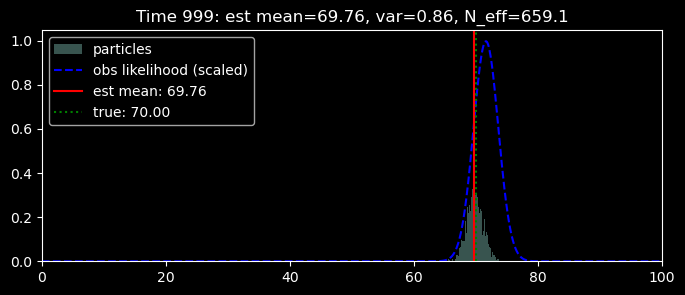

Demo finished. Use the ParticleFilter1D class for further experiments (non-analytic pdfs).


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import clear_output

def systematic_resample(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.uniform()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

class ParticleFilter1D:
    def __init__(self, N, prior_low=0.0, prior_high=100.0, motion_std=1.0):
        self.N = N
        self.particles = np.random.uniform(prior_low, prior_high, size=N)
        self.weights = np.ones(N) / N
        self.motion_std = motion_std

    def predict(self):
        self.particles += np.random.normal(scale=self.motion_std, size=self.N)

    def update(self, observation, obs_sigma):
        # compute importance weights from observation likelihood
        self.weights *= norm.pdf(observation, loc=self.particles, scale=obs_sigma)
        wsum = np.sum(self.weights)
        if wsum == 0:
            # avoid degeneracy: reset to uniform weights
            self.weights = np.ones(self.N) / self.N
        else:
            self.weights /= wsum

    def neff(self):
        return 1.0 / np.sum(self.weights ** 2)

    def resample_if_needed(self, threshold=None):
        if threshold is None:
            threshold = 0.5 * self.N
        if self.neff() < threshold:
            indexes = systematic_resample(self.weights)
            self.particles = self.particles[indexes].copy()
            self.weights.fill(1.0 / self.N)

    def estimate(self):
        mean = np.sum(self.particles * self.weights)
        var = np.sum((self.particles - mean)**2 * self.weights)
        return mean, var

# Demo: synthetic true state (random walk) and noisy observations
N = 1000
pf = ParticleFilter1D(N, prior_low=0.0, prior_high=100.0, motion_std=0.5)
true_state = 20.0
true_states = [true_state]
observations = []
obs_sigma = 2.0

for t in range(1000):
    # true state evolves
    #true_state += np.random.normal(scale=1.0)
    true_state += 0.05
    obs = true_state + np.random.normal(scale=obs_sigma)
    observations.append(obs)
    true_states.append(true_state)

    # PF steps
    pf.predict()
    pf.update(obs, obs_sigma)
    pf.resample_if_needed()
    mean, var = pf.estimate()

    # plot
    clear_output(wait=True)
    plt.figure(figsize=(8,3))
    plt.hist(pf.particles, bins=50, density=True, alpha=0.4, label='particles')
    xs = np.linspace(0,100,1000)
    # plot observation likelihood for reference
    plt.plot(xs, norm.pdf(xs, loc=obs, scale=obs_sigma) * 5, 'k--', label='obs likelihood (scaled)', color = 'blue')
    plt.axvline(mean, color='r', label=f'est mean: {mean:.2f}')
    plt.axvline(true_state, color='g', linestyle=':', label=f'true: {true_state:.2f}')
    plt.title(f'Time {t}: est mean={mean:.2f}, var={var:.2f}, N_eff={pf.neff():.1f}')
    plt.xlim(0,100)
    plt.legend()
    plt.show()

print('Demo finished. Use the ParticleFilter1D class for further experiments (non-analytic pdfs).')